# Project Milestone 2 Pipeline

Our pipeline has the following 4 major parts: 
##### 1. data cleaning and data quality analysis
##### 2. movie releases and genre over time 
##### 3. historical events scraping and plot analysis 
##### 4. historical evetns and genre analysis 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from enum import Enum


In [3]:
class Data(Enum):
    MOVIES = "movie.metadata.tsv"
    PLOTS = "plot_summaries.txt"
    NAME_CLUSTERS = "name.clusters.txt"

def load_data(type : Data, columns, index_col = ""):
    return pd.read_csv(
        f'./MovieSummaries/{type.value}', 
        sep="\t", 
        names=columns,
        index_col=index_col if index_col != "" else columns[0]
    )

movie_df = load_data(
    Data.MOVIES, 
    ["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"],
)
plot_df = load_data(
    Data.PLOTS, 
    ["wiki_id", "plot"]
)
name_df = load_data(
    Data.NAME_CLUSTERS, 
    ["character_name", "freebase_id"],
    index_col="freebase_id"
)

## Data Cleaning
Here we match the movies metadata with the plot summaries, and clean out unnecessary punctuations, parse strings into separate, processable values. 

In [4]:

# Parses the multi value structure of the dataset format into a sorted array of items
# Returns null values for empty lists as NaN (so all missing values we use are NaN)
def parse_multi_values(x): 
    if not x: 
        return []
    x = x.split(',')
    result = []
    for combo in x: 
        combo = combo.split(":")
        if len(combo) > 1: 
            combo[1] = re.sub("[^a-zA-Z0-9\s]+", "", combo[1])
            combo[1] = re.sub("^\s", "", combo[1])
            combo[1] = combo[1].strip()
            result.append(combo[1])
    if not result:
        return []
    return sorted(result)

# Add plot summaries to the movie df
movie_df = movie_df.join(plot_df)

# Parses the language column specifically by removing "Langauge" from each entry
def parse_language(languages):
    if not languages or type(languages) != list:
        return []
    return list(map(lambda l : l.replace("Language", "").strip(), languages))

# Parses the date format into an int representing only the year. Values with missing entries are given NaN.
def parse_date(x):
    if not x or x == np.nan:
        return np.NaN
    return str(x).split("-")[0]

# Parse multi value attributes into arrays
for attribute in ["languages", "countries", "genres"]:
    movie_df[attribute] = movie_df[attribute].apply(parse_multi_values)

# Remove "Language" from language column
movie_df["languages"] = movie_df["languages"].apply(parse_language)

# Parse release-date to all use the year as an int (don't need increased granularity right now)
movie_df["release_date"] = movie_df["release_date"].apply(parse_date)

# Replace missing numeric values with zero and convert to int rather than float
for col in ["runtime", "revenue"]:
    movie_df[col] = movie_df[col].fillna(0)
    movie_df[col] = movie_df[col].astype(int)

display(movie_df.head(3))

,freebase_id,name,release_date,revenue,runtime,languages,countries,genres,plot
wiki_id,,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001,14010832,98,[English],[United States of America],"[Action, Adventure, Horror, Science Fiction, S...","Set in the second half of the 22nd century, th..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000,0,95,[English],[United States of America],"[Biographical film, Crime Drama, Drama, Mystery]",NaN
28463795,/m/0crgdbh,Brun bitter,1988,0,83,[Norwegian],[Norway],"[Crime Fiction, Drama]",NaN


### Analyzing missing values
Here we have a rough idea of the quality of the data, where we realized the genre data is relatively complete among the dataset. 

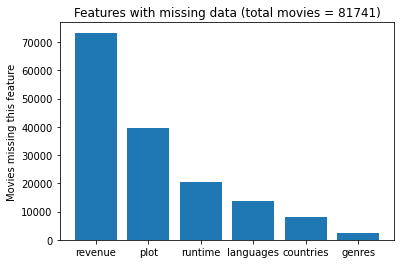

Rows without any missing data is 42204


In [5]:
# Let's check to what extent we have missing data
# For each column, count the number of missing data and plot a bar graph
def analyze_missing_values(df : pd.DataFrame): 
    # Dictionary from col to missing values count 
    missing = {}
    for col in df.columns:
        # Missing are na or empty falsy values such as empty lists
        num_missing = df[col].isna().sum() + (df[col].astype(bool) == False).sum()
        if num_missing > 0:
            missing[col] = num_missing
    missing = sorted(missing.items(), key=lambda x: x[1], reverse=True)
    plt.bar(
        list(map(lambda x : x[0], missing)), 
        list(map(lambda x : x[1], missing)),
    )
    plt.title("Features with missing data (total movies = " + str(df.shape[0]) + ")")
    plt.ylabel("Movies missing this feature")
    plt.show()

    # Count how many rows are without any missing values
    non_missing = (df.notnull().all(axis="columns") == True).sum()
    print("Rows without any missing data is", non_missing)

analyze_missing_values(movie_df)

## Since we are interested in how movies change over time, we are removing all the values without release_date
movie_df['release_date']
movie_df = movie_df[movie_df['release_date'] != 'nan']
movie_df = movie_df[movie_df['release_date'] != '1010']


## Data Analysis Part 1: movie releases and genre over time 
### How many movies are released per year? 
It's obvious to see from the graph beneath the the number of movies has increased significantly since 2005, with over 1500 movies released per year

Text(0.5, 1.0, 'The number of movies released by year')

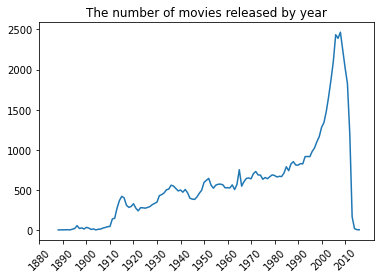

In [6]:

# Function that maps a list of items in a series 
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])
    
number_by_year = movie_df.groupby('release_date')['name'].count()
years = list(range(1888, 2017, 1))
fig, ax = plt.subplots()
ax.plot(years, number_by_year.values )
plt.xticks(np.arange(1880, 2015, 10), rotation = 45) 
plt.title("The number of movies released by year")

### How does the frequency of genres change over time? 
* First, we cleaned up the genre cateogries into broader, more generalizable categories. 
  * a few examples of the cleaning efforts "biographical film" is shortened to "biographical", "actionadventure" is split into "action" and "adventure", and "romance" is combined with "romantic" 
* Then, we observe the number of films of certain genre released over time

In [7]:
# separate a word like "pyschological thriller" to "psychological" and "thriller"
def combine_lists(elements):
    result = []
    for x in elements: 
        result += x
    return result
    
movie_df['genre_divided'] = movie_df['genres'].apply(lambda x: [word.lower().split(" ") for word in x]).apply(combine_lists)

## remove certain meaningless keywords from "genre", like "film", "movies"
## remove repeated words by changing to set; 
# if a film is ["romatic comedy", "dark comedy"], it would become ["romatic", "dark", "comedy"]
no_meaning_words = {"film", "movies", "of", "movie", "cinema"}
def remove_certain_genre(l):
    l = set(l)
    for word in no_meaning_words:
        if word in l: 
            l.remove(word)
    return list(l)
movie_df['genre_divided'] = movie_df['genre_divided'].apply(remove_certain_genre)
## swap words in listA to the list in listB 
## "romantic" is equal to "romance", and "actionadventure" is equal to "action" + "adventure"
listA = ['romantic', 'actionadventure', 'comedydrama', 'childrensfamily']
listB = [['romance'], ['action', 'adventure'], ['comedy', 'drama'], ['childrens', 'family']]
def swap_certain_genre (l):
    for word in l:
        if word in listA: 
            ind = listA.index(word)
            l.remove(word)
            l += listB[ind]

    return list(set(l))
movie_df['genre_divided'] = movie_df['genre_divided'].apply(swap_certain_genre)
display(movie_df[['release_date', 'genre_divided']].head(10)) 
# focus on the top 10 genres, as the ones beneath have less data 
# science fiction, animation and documentary are beneath -- might be worth looking at later 
top_ten_list = list(to_1D(movie_df['genre_divided']).value_counts().index[0:10])
print("The top ten genres after cleaning are" , top_ten_list)

,release_date,genre_divided
wiki_id,,
975900,2001,"[action, space, adventure, science, fiction, w..."
3196793,2000,"[mystery, drama, biographical, crime]"
28463795,1988,"[drama, crime, fiction]"
9363483,1987,"[erotic, thriller, psychological]"
261236,1983,[drama]
13696889,1913,"[comedy, indie, short, silent, blackandwhite]"
18998739,2002,"[adventure, fantasy, world, family]"
10408933,1938,"[comedy, blackandwhite, musical]"
9997961,1974,"[comedy, drama, musical]"


The top ten genres after cleaning are ['drama', 'comedy', 'romance', 'fiction', 'action', 'thriller', 'blackandwhite', 'adventure', 'crime', 'short']


#### How many films of the top ten genres are made per year? 

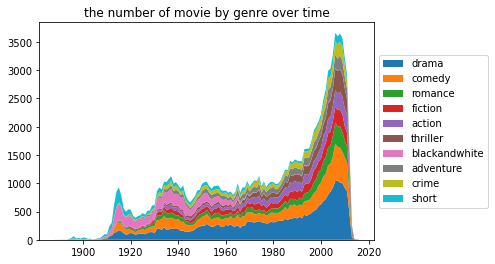

<AxesSubplot:title={'center':'the number of movie by genre over time'}>

In [8]:
## The following code prepares another dataframe for plotting 
stackplot_df = movie_df[['release_date', 'genre_divided']].copy()
for genre in top_ten_list: 
    stackplot_df[genre] = 0

for genre in top_ten_list:
    stackplot_df[genre] = stackplot_df["genre_divided"].apply(lambda x: 1 if genre in x else 0)

## the function for plotting, labels and df need to match 
def plot_stack_plot (df, labels, years, title): 
    vstack = []
    for genre in top_ten_list: 
        vstack.append(list(df[genre]))

    vstack = np.vstack(vstack)
    fig, ax = plt.subplots()
    ax.stackplot(years, vstack, labels= top_ten_list)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title(title)
    plt.show()
    return ax


grouped_by = stackplot_df.groupby(by='release_date').sum().reset_index()
years = list(range(1888, 2017, 1))
plot_stack_plot(grouped_by, top_ten_list, years, "the number of movie by genre over time")

#### Normalized genres 
We realize taht the above result might be affected by the number of labels it has. For example, a movie as ["comedy", "romance", and "blackandwhite" ] would contribute more to the graph. So we normalized the result. 

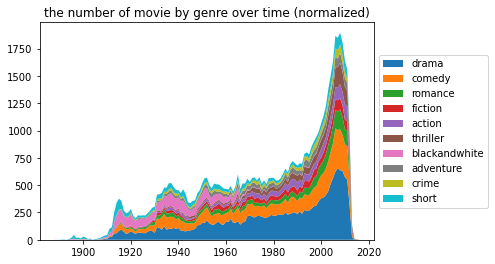

<AxesSubplot:title={'center':'the number of movie by genre over time (normalized)'}>

In [9]:
normalized_stack_df = stackplot_df.copy()
normalized_stack_df['sum'] = normalized_stack_df.iloc[:, 2:12].sum(axis=1)
for genre in top_ten_list:
    normalized_stack_df[genre] = normalized_stack_df[genre] / normalized_stack_df['sum']

normalized_group_by = normalized_stack_df.groupby(by='release_date').sum().reset_index()
plot_stack_plot(normalized_group_by, top_ten_list, years, "the number of movie by genre over time (normalized)")

#### Genre change in terms of percentage 

,release_date,drama,comedy,romance,fiction,action,thriller,blackandwhite,adventure,crime,short,sum
124,2012,0.277675,0.200371,0.114409,0.072975,0.116883,0.110699,0.001237,0.042672,0.039579,0.023500,1617
125,2013,0.170455,0.132576,0.053030,0.151515,0.166667,0.155303,0.000000,0.102273,0.064394,0.003788,264
126,2014,0.235294,0.117647,0.176471,0.058824,0.058824,0.058824,0.000000,0.294118,0.000000,0.000000,17
127,2015,0.000000,0.125000,0.000000,0.375000,0.250000,0.000000,0.000000,0.125000,0.125000,0.000000,8
128,2016,0.000000,0.000000,0.200000,0.200000,0.200000,0.400000,0.000000,0.000000,0.000000,0.000000,5


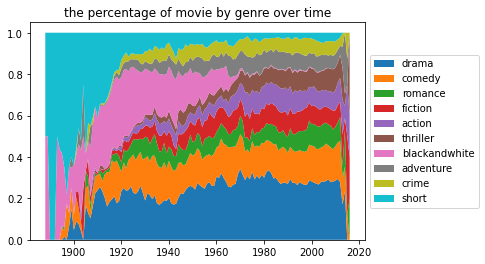

<AxesSubplot:title={'center':'the percentage of movie by genre over time'}>

In [10]:
percentage_df = grouped_by.copy()
percentage_df['sum'] = percentage_df.iloc[:, 1:11].sum(axis=1)
for genre in top_ten_list:
    percentage_df[genre] = percentage_df[genre]/percentage_df['sum']

display(percentage_df.tail(5))

plot_stack_plot(percentage_df, top_ten_list, years, "the percentage of movie by genre over time")

### Data Analysis Part 1 conclusion
* We can see that there is a sharp increase in the number of movies made since the 2000s 
* Black and white movies almost disappeared completely after 1970s
* Short movies are less frequent 

## Data Analysis Part 2: Statistical tests, Genre vs Historical Events

In [11]:
from scipy import stats

In [12]:
def movies_by_genre_over_time(df, genre):
    """
    Get the nbr of movies with a particular genre for every year and the fraction
    nbr movies of genre / total nbr of movies (for a given year)

    returns: DataFrame (cols = [release_date, genre_count, total_count, fraction])
    """
    mask = df['genres'].apply(lambda x: genre in x)
    genre_df = df[mask]
    genre_df = genre_df.groupby(by='release_date').count()[['name']]
    genre_df = genre_df.rename(columns={'name': f'{genre}_count'})
    df2 = df.groupby(by='release_date').count()[['name']]
    genre_df['total_count'] = df2['name']
    genre_df['fraction'] = genre_df[f'{genre}_count'] / genre_df['total_count']
    return genre_df

In [13]:
def get_idx_from_date(df, event_year):
    """
    Returns the index for a year in the df received from the movies_by_genre_over_time-function
    """
    idx = 0
    for year in df.index.values:
        if year == event_year:
            return idx
        idx += 1

def run_ttest_on_event(event, df):
    """
    Runs a t-test comparing the fraction of movies made by genre BEFORE vs AFTER the event occured

    params:
        event: dict
        df: DataFrame

    return: 
        scipy.stats.ttest
    """

    date = event['date']
    if len(date) == 9:
        start_date = date.split('-')[0]
        end_date = date.split('-')[1]

        start_idx = get_idx_from_date(df, start_date)
        end_idx = get_idx_from_date(df, end_date)
        before_event = df.iloc[:start_idx]
        after_event = df.iloc[end_idx:]

    else:
        idx = get_idx_from_date(df, date)
        before_event = df.iloc[:idx]
        after_event = df.iloc[idx:]

    return stats.ttest_ind(before_event['fraction'], after_event['fraction'])

In [14]:
# How to use these functions
war_movie_df = movies_by_genre_over_time(movie_df, 'War film')
event = {'name': 'World War II', 'date': '1939-1945', 'link': 'https://en.wikipedia.org/wiki/World_War_II'}

run_ttest_on_event(event, war_movie_df)

Ttest_indResult(statistic=-3.154620348362382, pvalue=0.002134291877531837)

In [15]:
import json
# Import all historical events
f = open('AnnotatedListOfEvents.json')
event_data = json.load(f)
event_data = event_data['events']

# Run t-tests on all events and all genres

In [20]:
def convert_list_to_string(list_):
    string = ""
    for idx, e in enumerate(list_):
        if idx == len(list_)-1:
            string += str(e)
        else:
            string += str(e) + ", "
    return string

def get_all_unique_genres(df: pd.DataFrame) -> list:
    """
    returns all unique genres in the df
    """
    mydf = df.copy()
    mydf['genres'] = mydf['genres'].apply(lambda x: convert_list_to_string(x))
    genre_list = mydf['genres'].unique()
    genres = []
    for genre in genre_list:
        genre_list = genre.split(', ')
        for e in genre_list:
            genres.append(e)
    genres = list(set(genres))
    return genres

In [21]:
def filter_significant_tests(list_of_tests, alpha):
    """
    Returns a list of tests that is significant on significance level alpha
    """
    return [x for x in list_of_tests if x[2][1] < alpha]

In [22]:
# Run t-tests to determine significance in rise/fall of popularity for every genre before vs after every historical event

genres = get_all_unique_genres(movie_df)
ttest_list = []
genre_dfs = []
for genre in genres:
    genre_dfs.append(movies_by_genre_over_time(movie_df, genre))
for event in event_data:
    for genre_df in genre_dfs:
        ttest = run_ttest_on_event(event, genre_df)
        ttest_list.append([event, str(genre_df.columns[0]).replace('_count', ''), ttest])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [24]:
# Significance level alpha = 0.005
significant_ttests = filter_significant_tests(ttest_list, 0.005)

In [27]:
print("Number of tests done (Event vs Production of Genre Combinations):", len(ttest_list))
print("Number of significant (alpha = 0.005) increases / descreases after event:", len(significant_ttests))

Number of tests done (Event vs Popularity of Genre Combinations): 12376
Number of significant (alpha = 0.005) increases / descreases after event: 1512


In [28]:
significant_ttests[765]

[{'name': 'President Kennedy Is Assassinated',
  'date': '1963',
  'link': 'https://en.wikipedia.org/wiki/Assassination_of_John_F._Kennedy'},
 'Horror',
 Ttest_indResult(statistic=-9.8853092591525, pvalue=1.013981982037517e-16)]

The cell above indicates that after "President Kennedy Is Assasinated" occured the production of the "Horror"-genre INCREASED, the p-value of this is: p ≈ 1.01e-16

In [36]:
significant_ttests[10]

[{'name': "Albert Einstein's formulation of special relativity",
  'date': '1905',
  'link': 'https://en.wikipedia.org/wiki/Theory_of_relativity'},
 'Silent film',
 Ttest_indResult(statistic=4.5711180088151275, pvalue=1.9662521689840835e-05)]

The cell above indicates that after "Albert Einstein's formulation of special relativity" occured the production of the "Silent film"-genre DECREASED, the p-value of this is: p ≈ 2.0e-5

### Comments

At the significance level $\alpha$ = 0.005, 1,512 out of 12,376 turned out "significant". But the exampel above suggests that there still are combinations in this set which doesn't make sense. The event of Albert Einstein publishing his work on special relativity propably didn't cause the genre "Silent film" to decrease. We treat the results from the t-tests above as an initial filter. Now we can do further analysis these combinations. The next step of the analysis will be to compare plot summaries of movies to Wikipedia summaries events. By doing this we might be able to see if there actually is any similarity between the historical event and movies that followed it. Example; the plot summaries of the "Silent films" that followed Einstein's discovery probabaly won't have anything to do with special relativity and we can rule them out.

## Data Analysis Part 3: Plot Summaries and Historical Events Similarity

In [ ]:
%pip install gensim
%pip install nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import pathlib
import multiprocessing

In [37]:
plot_df = movie_df.copy()
plot_df = plot_df[plot_df['plot'].notna()]

In [ ]:
import string

def parseDocument(doc):
        # TODO: probably don't need stuff to remove puctuation eg since that should be handled by word_tokenizer
        return word_tokenize(doc.lower().replace('\n', ' ').replace('\r', '').translate(str.maketrans('', '', string.punctuation)))

# Tokenize all plots 
tokenized_df = movie_df.copy() 
tokenized_summaries = tokenized_df['plot'].values
tokenized_summaries = [TaggedDocument(parseDocument(doc), [idx]) for idx, doc in enumerate(tokenized_summaries)]

In [ ]:
# Loads existing model from disk if available else trains new model
# Set force_train_new to True to train a new model even if a previous model exists
def create_doc2vec_model(documents, force_train_new = False):
    fname = str(pathlib.Path().resolve()) + "/doc2vec_model"
    if not force_train_new:
        # Try to load, if it succeeds then previous model existed so return that one
        try:
            return Doc2Vec.load(fname)
        except:
            print("Failed to load existing model")

    # Train model
    print("Start training of Doc2Vec model...")
    model = Doc2Vec(
        documents, 
        window=2, 
        min_count=1, 
        workers=multiprocessing.cpu_count(), 
        epochs = 100
    )
    
    # Persist the model
    print(f"Finished training Doc2Vec, saving it to file {fname}")
    model.save(fname)
    return model

# Train the doc2vec model
model = create_doc2vec_model(tokenized_summaries, force_train_new=False)

In [ ]:
apollo_wiki = """Apollo 13 (April 11–17, 1970) was the seventh crewed mission in the Apollo space program and the third meant to land on the Moon. The craft was launched from Kennedy Space Center on April 11, 1970, but the lunar landing was aborted after an oxygen tank in the service module (SM) failed two days into the mission. The crew instead looped around the Moon and returned safely to Earth on April 17. The mission was commanded by Jim Lovell, with Jack Swigert as command module (CM) pilot and Fred Haise as Lunar Module (LM) pilot. Swigert was a late replacement for Ken Mattingly, who was grounded after exposure to rubella.

A routine stir of an oxygen tank ignited damaged wire insulation inside it, causing an explosion that vented the contents of both of the SM's oxygen tanks to space. Without oxygen, needed for breathing and for generating electric power, the SM's propulsion and life support systems could not operate. The CM's systems had to be shut down to conserve its remaining resources for reentry, forcing the crew to transfer to the LM as a lifeboat. With the lunar landing canceled, mission controllers worked to bring the crew home alive.

Although the LM was designed to support two men on the lunar surface for two days, Mission Control in Houston improvised new procedures so it could support three men for four days. The crew experienced great hardship, caused by limited power, a chilly and wet cabin and a shortage of potable water. There was a critical need to adapt the CM's cartridges for the carbon dioxide scrubber system to work in the LM; the crew and mission controllers were successful in improvising a solution. The astronauts' peril briefly renewed public interest in the Apollo program; tens of millions watched the splashdown in the South Pacific Ocean on television.

An investigative review board found fault with preflight testing of the oxygen tank and Teflon being placed inside it. The board recommended changes, including minimizing the use of potentially combustible items inside the tank; this was done for Apollo 14. The story of Apollo 13 has been dramatized several times, most notably in the 1995 film Apollo 13 – based on Lost Moon, the 1994 memoir co-authored by Lovell – and an episode of the 1998 miniseries From the Earth to the Moon."""
test_doc = parseDocument(apollo_wiki)
test_vector = model.infer_vector(test_doc)

top_similar = model.dv.most_similar(positive=[test_vector],topn=100)
# Reminder, id here is the natural index from movie_df
top_similar_df = pd.DataFrame(top_similar, columns=["id", "similarity"]).set_index("id")

movie_df = movie_df.reset_index(drop=True)

top_similar_df = pd.merge(top_similar_df, movie_df, left_index=True, right_index=True)[["name", "similarity", "release_date", "plot"]]
top_similar_df